In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Read the training data file

In [ ]:
store_sales = pd.read_csv("train.csv")
store_sales.head (10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Checking for null values

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping store and item columns

In [ ]:
store_sales = store_sales.drop(['store', 'item'], axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
store_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


Since the date in the data is of object datatype we need to convert it into date type

In [ ]:
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [ ]:
store_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


Since we are to train the model to predict the sales in the next month, we need to convert the date into  the peroid of months. And the we sum the number of itmes in each month.


Remember: in our data set we have data about sales in accordance to everyday.


In [ ]:
print(store_sales['date'].dtype)


datetime64[ns]


below is the code where we see date now in each month and respective sales over the month.

In [ ]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()
print(monthly_sales)

       date    sales
0   2013-01   454904
1   2013-02   459417
2   2013-03   617382
3   2013-04   682274
4   2013-05   763242
5   2013-06   795597
6   2013-07   855922
7   2013-08   766761
8   2013-09   689907
9   2013-10   656587
10  2013-11   692643
11  2013-12   506607
12  2014-01   525987
13  2014-02   529117
14  2014-03   704301
15  2014-04   788914
16  2014-05   882877
17  2014-06   906842
18  2014-07   989010
19  2014-08   885596
20  2014-09   785124
21  2014-10   758883
22  2014-11   800783
23  2014-12   578048
24  2015-01   552513
25  2015-02   551317
26  2015-03   730951
27  2015-04   824467
28  2015-05   926902
29  2015-06   937184
30  2015-07  1037350
31  2015-08   920401
32  2015-09   823332
33  2015-10   797253
34  2015-11   827645
35  2015-12   607572
36  2016-01   602439
37  2016-02   614957
38  2016-03   790881
39  2016-04   901950
40  2016-05   988730
41  2016-06  1022664
42  2016-07  1138718
43  2016-08   981494
44  2016-09   896831
45  2016-10   863637
46  2016-11  

In [ ]:
print(store_sales)

           date  sales
0       2013-01     13
1       2013-01     11
2       2013-01     14
3       2013-01     13
4       2013-01     10
...         ...    ...
912995  2017-12     63
912996  2017-12     59
912997  2017-12     74
912998  2017-12     62
912999  2017-12     82

[913000 rows x 2 columns]


In [ ]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   date    60 non-null     period[M]
 1   sales   60 non-null     int64    
dtypes: int64(1), period[M](1)
memory usage: 1.1 KB


converting the resulting date column to timestamp datatype

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
# there was an error while trying to convert to timestamp saying "'DatetimeProperties' object has no attribute 'to_timestamp"


# monthly_sales.info()


Visulalization

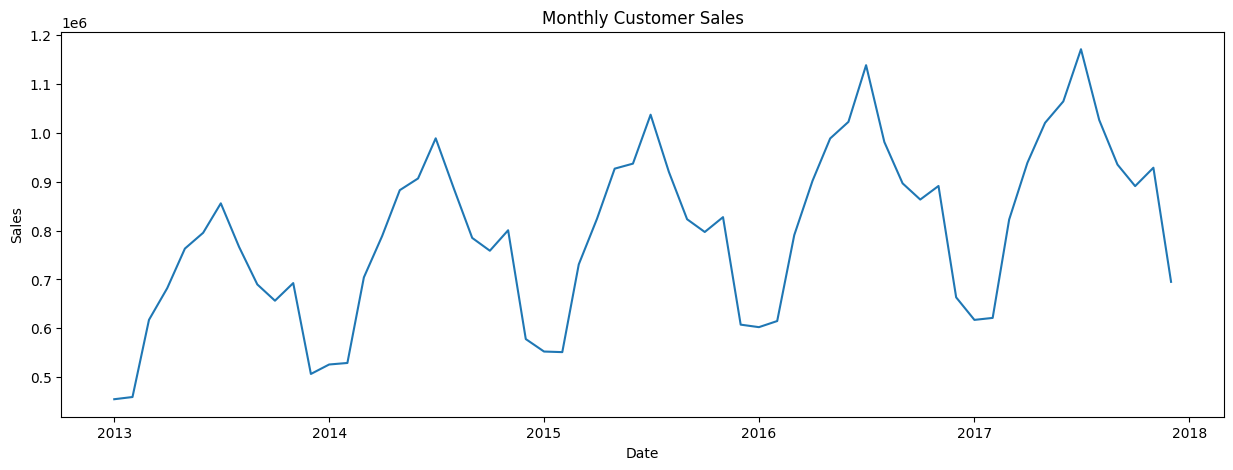

In [ ]:
plt.figure(figsize=(15,5))
#figure(figsize=(15,5)): This command creates a new figure for plotting. The figsize parameter is used to specify the width and height of the figure in inches. In this case, the figure is set to be 15 inches wide and 5 inches tall

plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel ("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

Call the difference on sales columns between months to make the sales data stationery

we just called the difference between the sales over 2 consecutive months.

In [ ]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
# monthly_sales['month_year'] = monthly_sales['date'].dt.strftime('%b %Y')

monthly_sales.head()

,date,sales,sales_diff
0,2013-01-01,454904,NaN
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0


In [ ]:
monthly_sales = monthly_sales.dropna() #drop not available
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


IN above the first row shows the data from feburary of 2013 and with the difference of sales subtracting to january of 2013

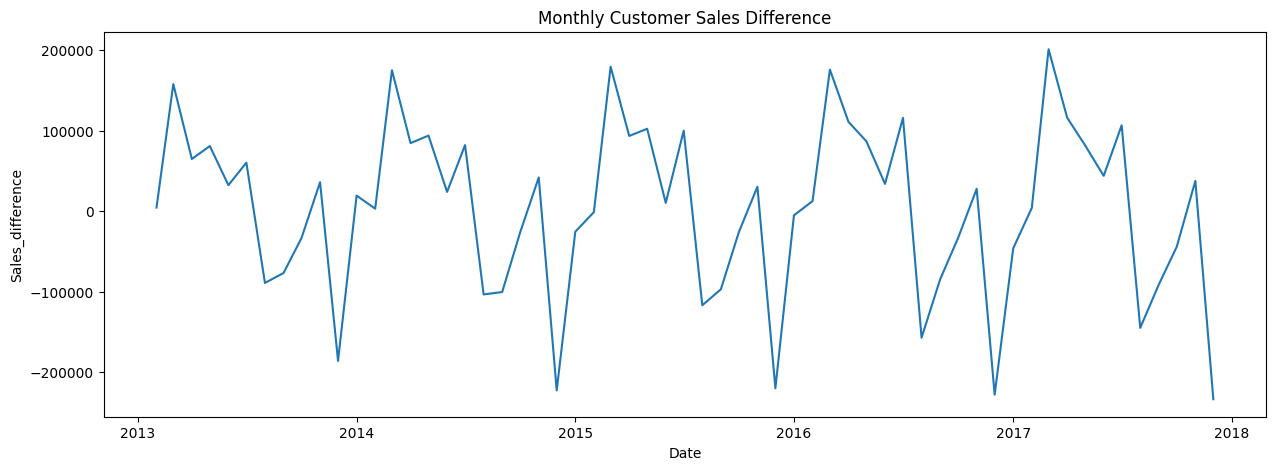

In [ ]:
#plottinc monthly customer sales difference
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff']) #used sales difference
plt.xlabel ("Date")
plt.ylabel("Sales_difference")
plt.title("Monthly Customer Sales Difference")
plt.show()

Now we need to train our models to predict the sale of the items in the next month and we will do that by looking at the sale of items in a specific number of previous month. So we need to prepare a supervised dataset to feed  into the model.

So in this we will be looking back into previous 12 month sale data to predict the sales in the sucessive 12 month.

Dropping off sales and date because we will only be dealing with statinoary sales data which we will use to train the ML model as well as the reinforcement model later.

In [ ]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
supervised_data.head(10)

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


In [ ]:
monthly_sales.head() # this shows that original monthlysales dataframe is not changed

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


now we need to prepare supervised data in a matter that the 12 month sale or the previous 12 month sale will be used as the input feature and the next 12 month sale will be used as the output of the model.

preparing the supervised data

In [ ]:
supervised_data.head(10)

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


In [ ]:
for i in range(1,13):# this will iterate over 12 months i.e. 1 to 12
  col_name = 'month_'+ str(i)
  supervised_data[col_name]= supervised_data['sales_diff'].shift(i)
  #sales_diff.shift(1), you are creating a new column where each value represents the sales difference from the previous month.
  # Positive i: Shifting the values down (forward in time). For example, if you have a column 'sales_diff' and you use sales_diff.shift(1), it will shift all values down by one position.

supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Splitting the data into train and test data

In [ ]:
train_data = supervised_data[:-12] #is creating a new DataFrame train_data by selecting all rows from the supervised_data DataFrame except for the last 12 rows.
test_data = supervised_data[-12:] #12th from the end to the end

print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)


train data shape:  (35, 13)
test data shape:  (12, 13)


next is using the min max scalar which basically is used to scale the feature values to restrict them to a range of -1 and 1.

Feature scaling is a method used to normalize the range of independent variables or features of data. In data processing, it is also known as data normalization and is generally performed during the data preprocessing step. Just to give you an example — if you have multiple independent variables like age, salary, and height; With their range as (18–100 Years), (25,000–75,000 Euros), and (1–2 Meters) respectively, feature scaling would help them all to be in the same range, for example- centered around 0 or in the range (0,1) depending on the scaling technique.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)



In [ ]:
print(train_data)

[[ 0.13408606  0.20344758 -0.81758535  0.28633667 -0.05850103 -0.27488947
  -0.33606217  0.40696724  0.26794062  0.50957454  0.42966779  0.8922929
   0.12955024]
 [ 0.97816867  0.12267595  0.20344758 -0.81758535  0.28633667 -0.05850103
  -0.27488947 -0.33606217  0.40696724  0.26794062  0.50957454  0.42966779
   0.8922929 ]
 [ 0.53383488  0.977881    0.12267595  0.20344758 -0.81758535  0.28633667
  -0.05850103 -0.27488947 -0.33606217  0.40696724  0.26794062  0.50957454
   0.42966779]
 [ 0.5797052   0.52769224  0.977881    0.12267595  0.20344758 -0.81758535
   0.28633667 -0.05850103 -0.27488947 -0.33606217  0.40696724  0.26794062
   0.50957454]
 [ 0.23630084  0.574167    0.52769224  0.977881    0.12267595  0.20344758
  -0.81758535  0.28633667 -0.05850103 -0.27488947 -0.33606217  0.40696724
   0.26794062]
 [ 0.52183992  0.22623761  0.574167    0.52769224  0.977881    0.12267595
   0.20344758 -0.81758535  0.28633667 -0.05850103 -0.27488947 -0.33606217
   0.40696724]
 [-0.38860993  0.515539

In [ ]:
print(test_data)

[[-0.10745675 -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168  0.27578914  0.53846345  0.65919343  0.98155922  0.16933959
   0.0816042 ]
 [ 0.13866328 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343  0.98155922
   0.16933959]
 [ 1.10628178  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343
   0.98155922]
 [ 0.68877355  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345
   0.65919343]
 [ 0.52015228  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914
   0.53846345]
 [ 0.33428672  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168
   0.27578914]
 [ 0.64253037  0.32551

splitting the input and the output data

In [ ]:
X_train, Y_train = train_data[:,1:], train_data[:,0:1]
#train_data[:, 1:]: This slices the train_data array to include all rows and all columns starting from the second column (index 1) to the last column. This assumes that the features you want to use for training are in columns 2 and onward.
# train_data[:, 0:1]: This slices the train_data array to include all rows and only the first column. This assumes that the target variable you want to predict is in the first column.
X_test, Y_test = test_data[:,1:], test_data[:,0:1]
Y_train = Y_train.ravel() #If y_train is a 2D array (for example, a column vector), ravel() will convert it to a 1D array.
Y_test = Y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("Y_train Shape: ", Y_train.shape)
print("X_test Shape: ", X_test.shape)
print("Y_test phape: ", Y_test.shape)


X_train Shape:  (35, 12)
Y_train Shape:  (35,)
X_test Shape:  (12, 12)
Y_test phape:  (12,)


Make prediction data frame to merge the predicetd sales prices of all trained algs

In [ ]:
#  extract the last 12 dates from the 'date' column in the 'monthly_sales' DataFrame and store them in a new variable called 'sales_dates'.
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)

# reset_index(drop=True): This resets the index of the resulting series and drops the old index, so the new 'sales_dates' series starts with an index of 0 and continues sequentially.

predict_df = pd.DataFrame(sales_dates)
print(predict_df)

         date
0  2017-01-01
1  2017-02-01
2  2017-03-01
3  2017-04-01
4  2017-05-01
5  2017-06-01
6  2017-07-01
7  2017-08-01
8  2017-09-01
9  2017-10-01
10 2017-11-01
11 2017-12-01


We also need to extract the actual monthly sales value of the last 13 months as they correspond to test data set.



In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list() # extracting the actual sales of the last thirtneen months
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Forecasting sales using linear regression.

here we create the linear regression model and then predict the output



In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
lr_pre = lr_model.predict(X_test)

In [ ]:
print(lr_pre)

[ 0.0427074   0.17284957  1.09083796  0.71220971  0.58376708  0.33753568
  0.79053303 -0.71169155 -0.29772672 -0.01470231  0.24425358 -1.02944627]


now we need to transform the predicted values into the original scale. We call for inserve transform function as below:

In [ ]:
lr_pre = lr_pre.reshape(-1,1)
# .reshape(-1, 1): The reshape method is used to change the shape of the array. The argument -1 is used as a placeholder, and it allows NumPy to automatically infer the number of rows based on the size of the original array. The second dimension is explicitly set to 1, indicating that the resulting array should have one column.

print(lr_pre)

[[ 0.0427074 ]
 [ 0.17284957]
 [ 1.09083796]
 [ 0.71220971]
 [ 0.58376708]
 [ 0.33753568]
 [ 0.79053303]
 [-0.71169155]
 [-0.29772672]
 [-0.01470231]
 [ 0.24425358]
 [-1.02944627]]


In [ ]:

#this is a  set matrix containing input features of the test data, and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
print(lr_pre_test_set)

[[ 0.0427074  -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352
   0.68397168  0.27578914  0.53846345  0.65919343  0.98155922  0.16933959
   0.0816042 ]
 [ 0.17284957 -0.12204966 -1.02635392  0.24535439 -0.05787474 -0.31370458
  -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343  0.98155922
   0.16933959]
 [ 1.09083796  0.12731349 -0.12204966 -1.02635392  0.24535439 -0.05787474
  -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345  0.65919343
   0.98155922]
 [ 0.71220971  1.10768225  0.12731349 -0.12204966 -1.02635392  0.24535439
  -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914  0.53846345
   0.65919343]
 [ 0.58376708  0.68467253  1.10768225  0.12731349 -0.12204966 -1.02635392
   0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168  0.27578914
   0.53846345]
 [ 0.33753568  0.51382935  0.68467253  1.10768225  0.12731349 -0.12204966
  -1.02635392  0.24535439 -0.05787474 -0.31370458 -0.67437352  0.68397168
   0.27578914]
 [ 0.79053303  0.32551

In [ ]:
# reverse the transforamtion applied
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

print(lr_pre_test_set)

[[-6.43855789e+14 -9.22984821e+15  1.12565154e+15 -1.34353823e+15
  -3.42675645e+15 -6.36367766e+15  4.69730488e+15  1.37348120e+15
   3.51243378e+15  4.49553599e+15  7.12055528e+15  5.06664256e+14
  -2.07763553e+14]
 [ 4.58336817e+14 -1.86611357e+15 -9.22984821e+15  1.12565154e+15
  -1.34353823e+15 -3.42675645e+15 -6.36367766e+15  4.69730488e+15
   1.37348120e+15  3.51243378e+15  4.49553599e+15  7.12055528e+15
   5.06664256e+14]
 [ 8.23291180e+15  1.64446414e+14 -1.86611357e+15 -9.22984821e+15
   1.12565154e+15 -1.34353823e+15 -3.42675645e+15 -6.36367766e+15
   4.69730488e+15  1.37348120e+15  3.51243378e+15  4.49553599e+15
   7.12055528e+15]
 [ 5.02625505e+15  8.14757309e+15  1.64446414e+14 -1.86611357e+15
  -9.22984821e+15  1.12565154e+15 -1.34353823e+15 -3.42675645e+15
  -6.36367766e+15  4.69730488e+15  1.37348120e+15  3.51243378e+15
   4.49553599e+15]
 [ 3.93845601e+15  4.70301188e+15  8.14757309e+15  1.64446414e+14
  -1.86611357e+15 -9.22984821e+15  1.12565154e+15 -1.34353823e+15


43


In [ ]:
# once we've calculated the predicted sales values from the differencevalues we are going to append it to that result list
result_list =[]
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+ act_sales[index])

lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [ ]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01      -6.438558e+14
1  2017-02-01       4.583368e+14
2  2017-03-01       8.232912e+15
3  2017-04-01       5.026255e+15
4  2017-05-01       3.938456e+15
5  2017-06-01       1.853087e+15
6  2017-07-01       5.689586e+15
7  2017-08-01      -7.032968e+15
8  2017-09-01      -3.527041e+15
9  2017-10-01      -1.130067e+15
10 2017-11-01       1.063068e+15
11 2017-12-01      -9.724079e+15
